In [45]:
import joblib
import matplotlib.pyplot as plt
import numpy as np
import os
import pywt  # For wavelet transforms
import sys

# MNE for EEG signal processing
from mne import Epochs, pick_types, events_from_annotations
from mne.channels import make_standard_montage
from mne.datasets import eegbci
from mne.decoding import CSP, Vectorizer
from mne.io import concatenate_raws, read_raw_edf

# Scikit-learn for machine learning
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import ShuffleSplit, cross_val_score, train_test_split, KFold
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.svm import SVC

# PyRiemann for Riemannian geometry approaches
from pyriemann.estimation import Covariances
from pyriemann.utils.covariance import covariances
from pyriemann.classification import MDM, TSclassifier
from pyriemann.tangentspace import TangentSpace

# Custom modules
sys.path.append('../models')
from wavelet import WaveletTransformer, extract_wavelet_features


# Investigating accuracy of simple decoders within subject 
The purpose of this notebook is to do a rough comparison of accuracy with cross subject training. The models trained here are not stored and should not be used for online decoding (streamed data is not within subject). 

### Loading data and preprocessing
Using all runs for motor imagery task classifying hands vs. feet on first subject.

In [46]:

#models_dir = '../models/trained/'

print(__doc__)


tmin, tmax = -1.0, 4.0
subjects = range(1, 2)  # Training on the first subject
runs = [6, 10, 14]  # Motor imagery: hands vs feet
raws = []

for subject in subjects:
    try:
        # Attempt to load the data for the current subject
        raw_fnames = eegbci.load_data(subject, runs)
        # For each subject, load their raw data and append to the 'raws' list
        raws.extend([read_raw_edf(f, preload=True) for f in raw_fnames])
        print(f"Successfully processed subject {subject}.")
    except Exception as e:
        # If an error occurs, skip to the next subject
        print(f"Error processing subject {subject}: {e}. Skipping to next subject.")
        continue

raw = concatenate_raws(raws)

Automatically created module for IPython interactive environment
Extracting EDF parameters from /Users/nana/Documents/GitHub/eeg/data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /Users/nana/Documents/GitHub/eeg/data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /Users/nana/Documents/GitHub/eeg/data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Successfully processed subject 1.


In [47]:
# Preprocessing
eegbci.standardize(raw)  # set channel names
montage = make_standard_montage("standard_1005")
raw.set_montage(montage)


# Apply band-pass filter
raw.filter(7.0, 30.0, fir_design="firwin", skip_by_annotation="edge")

picks = pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False, exclude="bads")

events, _ = events_from_annotations(raw, event_id=dict(T1=2, T2=3)) 
event_id = dict(hands=2, feet=3)


epochs = Epochs(
    raw,
    events = events, 
    event_id= event_id,
    tmin=tmin,
    tmax=tmax,
    proj=True,
    picks=picks,
    baseline=None,
    preload=True,
)
#epochs_train = epochs.copy().crop(tmin=1.0, tmax=2.0)
labels = epochs.events[:, -1] - 2

Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation


- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 265 samples (1.656 s)

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
45 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 45 events and 801 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
combining channels using "gfp"


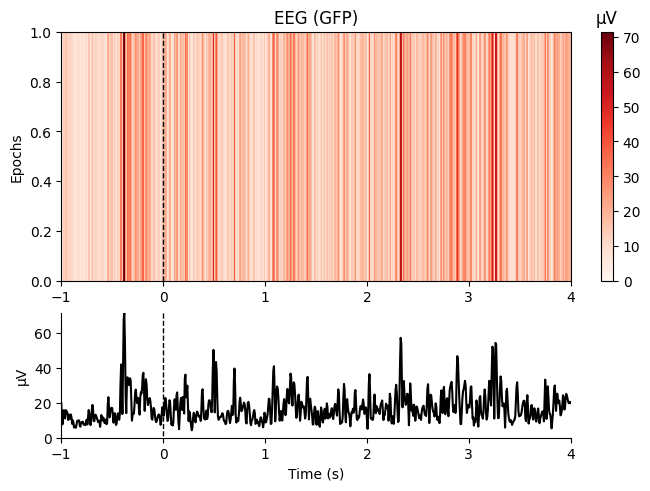

[<Figure size 640x480 with 3 Axes>]

In [48]:
epochs[0].plot_image()

### Feature decoding and classification

In [49]:
# Define a monte-carlo cross-validation generator (reduce variance):
scores = []
epochs_data = epochs.get_data(copy=False)
#epochs_data_train = epochs_train.get_data(copy=False)
cv = ShuffleSplit(10, test_size=0.2, random_state=42)
cv_split = cv.split(epochs_data)

In [50]:
# CSP + LDA

# Assemble a classifier
lda = LinearDiscriminantAnalysis()
csp = CSP(n_components=4, reg=None, log=True, norm_trace=False)

# Building Pipeline
clf = Pipeline([("CSP", csp), ("LDA", lda)])

# Fit the pipeline to the training data
clf.fit(epochs_data, labels)

# Scoring the pipeline
scores = cross_val_score(clf, epochs_data, labels, cv=cv, n_jobs=None)


# Printing the results
class_balance = np.mean(labels == labels[0])
class_balance = max(class_balance, 1.0 - class_balance)
print(f"Classification accuracy: {np.mean(scores)} / Chance level: {class_balance}")

# plot CSP patterns estimated on full data for visualization
#csp.fit_transform(epochs_data, labels)
#csp.plot_patterns(epochs.info, ch_type="eeg", units="Patterns (AU)", size=1.5)

Computing rank from data with rank=None


    Using tolerance 0.00025 (2.2e-16 eps * 64 dim * 1.7e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Done.
Computing rank from data with rank=None
    Using tolerance 0.00026 (2.2e-16 eps * 64 dim * 1.9e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Intel MKL WARNING: Support of I

Computing rank from data with rank=None
    Using tolerance 0.0002 (2.2e-16 eps * 64 dim * 1.4e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Done.
Computing rank from data with rank=None
    Using tolerance 0.00025 (2.2e-16 eps * 64 dim * 1.7e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 pro

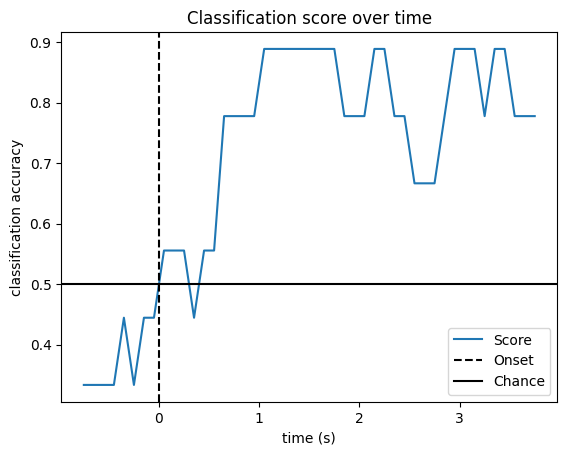

In [51]:
sfreq = raw.info["sfreq"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(epochs_data, labels, test_size=0.2, random_state=42)

# Transform data using CSP and fit LDA classifier as before
csp = CSP(n_components=4, reg=None, log=True, norm_trace=False)
lda = LinearDiscriminantAnalysis()

w_length = int(sfreq * 0.5)  # running classifier: window length
w_step = int(sfreq * 0.1)  # running classifier: window step size
w_start = np.arange(0, X_test.shape[2] - w_length, w_step)

scores_windows = []

# Transform training data once, since we're not using cross-validation loop here
X_train_transformed = csp.fit_transform(X_train, y_train)

# Fit classifier to transformed training data
lda.fit(X_train_transformed, y_train)

# Running classifier: test classifier on sliding window
score_this_window = []
for n in w_start:
    this_window = X_test[:, :, n : (n + w_length)]
    X_test_transformed = csp.transform(this_window)
    score_this_window.append(lda.score(X_test_transformed, y_test))
scores_windows.append(score_this_window)

# Plot scores over time
w_times = (w_start + w_length / 2.0) / sfreq + epochs.tmin

plt.figure()
plt.plot(w_times, np.mean(scores_windows, 0), label="Score")
plt.axvline(0, linestyle="--", color="k", label="Onset")
plt.axhline(0.5, linestyle="-", color="k", label="Chance")
plt.xlabel("time (s)")
plt.ylabel("classification accuracy")
plt.title("Classification score over time")
plt.legend(loc="lower right")
plt.show()


In [52]:
# CSP + Logistic Regression

lr = LogisticRegression()
csp = CSP(n_components=4, reg='ledoit_wolf', log=True)

clf = Pipeline([('CSP', csp), ('LogisticRegression', lr)])

# Fit the pipeline to the training data
clf.fit(X_train, y_train)

# Scoring the pipeline
y_pred = clf.predict(X_test)
score = accuracy_score(y_test, y_pred)

# Printing the results
print("CSP + Logistic Regression Classification accuracy: %f / Chance level: %f" % (score, class_balance))



Computing rank from data with rank=None
    Using tolerance 0.0002 (2.2e-16 eps * 64 dim * 1.4e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Reducing data rank from 64 -> 64
Estimating covariance using LEDOIT_WOLF
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Ex

In [53]:
# Wavelet + SVM

wavelet_transformer = WaveletTransformer(sfreq)
svm = SVC(kernel='rbf', gamma='auto', C=1.0)

clf = Pipeline([("Wavelet", wavelet_transformer), ("SVM", svm)])

# Fit the pipeline to the training data
clf.fit(X_train, y_train)

# Scoring the pipeline
y_pred = clf.predict(X_test)
score = accuracy_score(y_test, y_pred)

# Printing the results
print("Wavelet + SVM Regression Classification accuracy: %f / Chance level: %f" % (score, class_balance))


Wavelet + SVM Regression Classification accuracy: 0.333333 / Chance level: 0.533333


In [54]:
# CSP + SVM


csp = CSP(n_components=4, reg='ledoit_wolf', log=True)
svm = SVC(kernel='rbf', gamma='auto', C=1.0)
clf = Pipeline([('CSP', csp), ('SVM', svm)])

# Fitting the pipeline to the training data
clf.fit(X_train, y_train)

# Scoring the pipeline
y_pred = clf.predict(X_test)
score = accuracy_score(y_test, y_pred)

# Printing the results
print("CSP + SVM Classification accuracy: %f / Chance level: %f" % (score, class_balance))

Computing rank from data with rank=None
    Using tolerance 0.0002 (2.2e-16 eps * 64 dim * 1.4e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Reducing data rank from 64 -> 64
Estimating covariance using LEDOIT_WOLF
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Ex

In [55]:
from pyriemann.spatialfilters import CSP

# Creating the FBCSP + RandomForest pipeline
covest = Covariances(estimator='lwf')
fbcsp = CSP(nfilter=4,log=True)
vec = Vectorizer()
rf = RandomForestClassifier(n_estimators=100)

clf_fbcsp_rf = make_pipeline(covest, fbcsp, vec, rf)

# Fitting the pipeline to the training data
clf_fbcsp_rf.fit(X_train, y_train)

# Scoring the pipeline
y_pred_fbcsp_rf = clf_fbcsp_rf.predict(X_test)
score_fbcsp_rf = accuracy_score(y_test, y_pred_fbcsp_rf)

# Printing the results
print("FBCSP + RandomForest Classification accuracy: %f / Chance level: %f" % (score_fbcsp_rf, class_balance))


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [56]:

# Creating the RG + LogisticRegression pipeline
covest_rg = Covariances(estimator='lwf')
ts = TangentSpace(metric='riemann')
lr = LogisticRegression(solver='liblinear')

clf_rg_lr = make_pipeline(covest_rg, ts, lr)

# Fitting the pipeline to the training data
clf_rg_lr.fit(X_train, y_train)

# Scoring the pipeline
y_pred_rg_lr = clf_rg_lr.predict(X_test)
score_rg_lr = accuracy_score(y_test, y_pred_rg_lr)

# Printing the results
print("Riemannian Geometry + LogisticRegression Classification accuracy: %f / Chance level: %f" % (score_rg_lr, class_balance))


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
